In [1]:
import pyodbc
import pandas as pd
import os
from IPython.display import display, Markdown
from datetime import date
import numpy as np

import matplotlib.pyplot as plt

dbconn = os.environ.get('DBCONN', None)
if dbconn is None:
    display("No SQL credentials. Check that the file 'environ.txt' is present. Refer to readme for further information")
else:
    dbconn = dbconn.strip('"')

# import custom functions from 'analysis' folder
import sys
sys.path.append('../lib/')
    
from functions import closing_connection, load_filter_codelists, filter_codelists, plotting_all
codes = pd.read_csv(os.path.join('..','data','code_dictionary.csv'))

In [5]:

sql1 = f'''select 
    CTV3Code,
    CASE CTV3Code
      WHEN 'X772q' THEN 'cholesterol-2'
      WHEN 'XaPbt' THEN 'cholesterol-1'
      WHEN 'XE2eB' THEN 'bilirubin'
      END AS name,
    DATEFROMPARTS(YEAR(ConsultationDate), MONTH(ConsultationDate),1) AS month,
    COUNT(*) as events
    FROM CodedEvent
    WHERE CTV3Code IN ('X772q', 'XaPbt', 'XE2eB')
    AND ConsultationDate > '20171231'
    GROUP BY CTV3Code, 
    CASE CTV3Code
      WHEN 'X772q' THEN 'cholesterol-2'
      WHEN 'XaPbt' THEN 'cholesterol-1'
      WHEN 'XE2eB' THEN 'bilirubin'
      END,
    DATEFROMPARTS(YEAR(ConsultationDate), MONTH(ConsultationDate), 1)'''

    
with closing_connection(dbconn) as connection:
    df = pd.read_sql(sql1, connection)
    
df

,CTV3Code,name,month,events
0,X772q,bilirubin,2018-06-01,120545
1,XaPbt,cholesterol-1,2020-02-01,696758
2,XaPbt,cholesterol-1,2018-09-01,590258
3,XE2eB,cholesterol-2,2019-02-01,368799
4,XaPbt,cholesterol-1,2019-01-01,702321
...,...,...,...,...
131,XE2eB,cholesterol-2,2018-08-01,365181
132,X772q,bilirubin,2019-09-01,116541
133,XE2eB,cholesterol-2,2018-10-01,404341
134,X772q,bilirubin,2019-11-01,119706


In [6]:
sql1 = f'''select 
    COUNT(distinct Organisation_ID) as practices
    FROM RegistrationHistory
    WHERE YEAR(EndDate) = '9999'-- live registrations only
    '''

    
with closing_connection(dbconn) as connection:
    df = pd.read_sql(sql1, connection)
    
df

,practices
0,2541


In [4]:
sql1 = '''-- patient registrations
    SELECT
    Patient_ID,
    Organisation_ID AS Practice_ID,
    ROW_NUMBER() OVER (partition by Patient_ID ORDER BY StartDate DESC, EndDate DESC) AS registration_date_rank -- row_num gives unique results
    INTO #reg
    FROM RegistrationHistory
    WHERE YEAR(EndDate) = '9999'; -- live registrations only
    '''

sql2 = '''-- practice list size
    SELECT
    Organisation_ID AS Practice_ID,
    COUNT(DISTINCT Patient_ID) AS list_size
    INTO #listsize
    FROM RegistrationHistory
    WHERE YEAR(EndDate) = '9999' -- live registrations only  
    GROUP BY Organisation_ID
    '''

sql3 = f'''select 
    CTV3Code,
    CASE CTV3Code
      WHEN 'X772q' THEN 'cholesterol-2'
      WHEN 'XaPbt' THEN 'cholesterol-1'
      WHEN 'XE2eB' THEN 'bilirubin'
      END AS name,
    --DATEFROMPARTS(YEAR(ConsultationDate),MONTH(ConsultationDate),1) AS month, 
    CASE WHEN r.Practice_ID IS NOT NULL THEN 1 ELSE 0 END AS patient_currently_registered,
    COUNT(DISTINCT e.Patient_ID) as total_patients,
    COUNT(DISTINCT r.Practice_ID) as total_practices,
    count(*) as events
    --l.list_size as denominator
    --INTO #main
    FROM CodedEvent e
    LEFT JOIN #reg r ON e.Patient_ID = r.Patient_ID AND r.registration_date_rank = 1
    LEFT JOIN #listsize l ON r.Practice_ID = l.Practice_ID
    WHERE 
    ConsultationDate IS NOT NULL 
    AND CTV3Code IN ('X772q', 'XaPbt', 'XE2eB')
    AND ConsultationDate >= '20190101' 
    AND ConsultationDate < '20210101'
    GROUP BY 
    CTV3Code,     
    CASE CTV3Code
      WHEN 'X772q' THEN 'cholesterol-2'
      WHEN 'XaPbt' THEN 'cholesterol-1'
      WHEN 'XE2eB' THEN 'bilirubin'
      END,
    CASE WHEN r.Practice_ID IS NOT NULL THEN 1 ELSE 0 END--,
    --DATEFROMPARTS(YEAR(ConsultationDate), MONTH(ConsultationDate), 1)--, 
    --    r.Practice_ID, l.list_size
    --ORDER BY month
    '''

with closing_connection(dbconn) as connection:
    connection.execute(sql1) # patient registrations
    connection.execute(sql2) # practice list size
    df_new = pd.read_sql(sql3, connection)
    
df_new

,CTV3Code,name,patient_currently_registered,total_patients,total_practices,events
0,XaPbt,cholesterol-1,1,6873365,2536,12306867
1,XE2eB,bilirubin,0,162117,0,318313
2,XaPbt,cholesterol-1,0,277682,0,433373
3,X772q,cholesterol-2,1,1318247,2461,2190591
4,XE2eB,bilirubin,1,3531635,2522,6954120
5,X772q,cholesterol-2,0,50764,0,74968


In [81]:
dff2 = df_new.copy()
dff2 = dff2.set_index(["month", "name","patient_currently_registered"])[["events"]].unstack()
dff2.columns= dff2.columns.droplevel()
dff2["percent_with_no_current_reg"] = 100*(dff2[0]/(dff2[0]+dff2[1])).round(2)
display(dff2[["percent_with_no_current_reg"]].unstack().sort_index().head(5))
display(dff2[["percent_with_no_current_reg"]].unstack().sort_index().tail(5))

patient_currently_registered percent_with_no_current_reg                \
name                                           bilirubin cholesterol-1   
month                                                                    
2019-01-01                                           8.0           6.0   
2019-02-01                                           7.0           6.0   
2019-03-01                                           7.0           5.0   
2019-04-01                                           6.0           5.0   
2019-05-01                                           6.0           5.0   

patient_currently_registered                
name                         cholesterol-2  
month                                       
2019-01-01                             6.0  
2019-02-01                             6.0  
2019-03-01                             5.0  
2019-04-01                             5.0  
2019-05-01                             5.0

patient_currently_registered percent_with_no_current_reg                \
name                                           bilirubin cholesterol-1   
month                                                                    
2020-06-01                                           2.0           1.0   
2020-07-01                                           2.0           1.0   
2020-08-01                                           1.0           1.0   
2020-09-01                                           0.0           0.0   
2020-10-01                                           0.0           0.0   

patient_currently_registered                
name                         cholesterol-2  
month                                       
2020-06-01                             1.0  
2020-07-01                             1.0  
2020-08-01                             1.0  
2020-09-01                             0.0  
2020-10-01                             0.0

name,bilirubin,cholesterol-1,cholesterol-2
month,,,
2019-01-01,2261,2530,1768
2019-02-01,2254,2530,1633
2019-03-01,2250,2531,1639
2019-04-01,2225,2530,1504
2019-05-01,2216,2530,1515
2019-06-01,2184,2533,1514
2019-07-01,2195,2533,1534
2019-08-01,2145,2533,1419
2019-09-01,2095,2529,1393


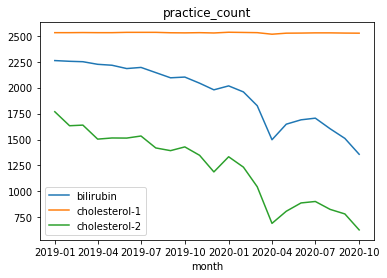

In [83]:
dff3 = df_new.copy()
dff3 = dff3.groupby(["month", "name"])[["total_practices"]].sum().unstack()
dff3.columns= dff3.columns.droplevel()
#dff2["percent_with_no_current_reg"] = 100*(dff2[0]/(dff2[0]+dff2[1])).round(2)
#display(dff2.sort_index().head(15))
#display(dff2.sort_index().tail(15))
dff3["bilirubin"].plot(legend=True, title="practice_count")
dff3["cholesterol-1"].plot(legend=True)
dff3["cholesterol-2"].plot(legend=True)

dff3

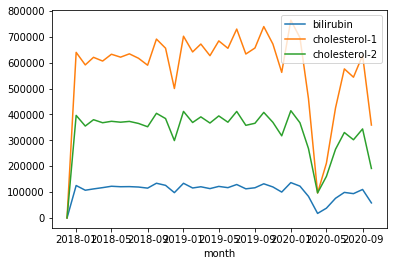

In [44]:

df0 = df.copy().set_index("month")
df0 = df0.loc[df0.index < date(2020,12,1)]
df1 = df0[df0["name"]=="bilirubin"].sort_index()
df2 = df0[df0["name"]=="cholesterol-1"].sort_index()
df3 = df0[df0["name"]=="cholesterol-2"].sort_index()

df1["events"].plot(label="bilirubin", legend=True)
df2["events"].plot(label="cholesterol-1", legend=True)
df3["events"].plot(label="cholesterol-2", legend=True)

High level codes: 2

Detailed codes: 484

# --- 
 # Category: Mental health disorder

Total events: 0.25 m

## Contents:

,first_digits,Description,2020 events (mill)
48,E2,"Neurotic, personality and other nonpsychotic d...",0.25


## "E2" - Neurotic, personality and other nonpsychotic disorders 
 ### (Practices included: 2.5k (100.0%); 2020 events: 0.25m)

Feb median: 1.2 (IDR 2.3), April median: 0.6 (IDR 1.7), September median: 0.9 (IDR 2.1)

Change from 2019: April -46.1% (Small drop); September -27.9%, (Small drop); Overall classification: **Sustained drop**

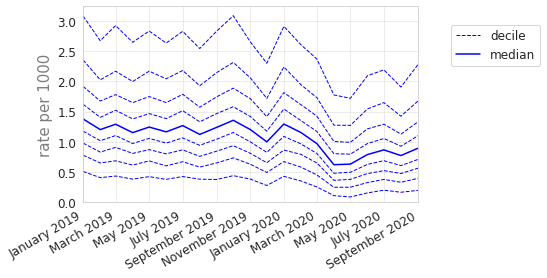

Top codes represented in chart above:

,first_digits,2020 events (thou),Description
0,E200,85.0,Anxiety disorder
1,E200z,59.8,Anxiety state NOS
2,E2273,21.9,Erectile dysfunction
3,E2002,21.4,Generalised anxiety disorder
4,E2B,14.7,Depressive disorder NEC


### Trend in top sub-code: E200 - Anxiety disorder

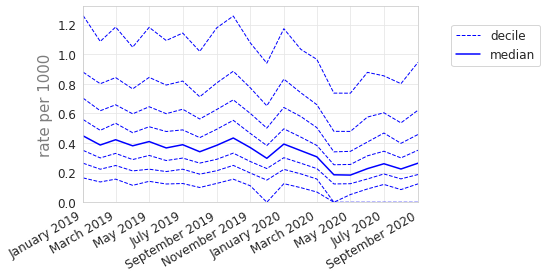

# --- 
 # Category: Operations, procedures and interventions

Total events: 0.04 m

## Contents:

,first_digits,Description,2020 events (mill)
117,28,Nervous system and mental state general examin...,0.04


../lib/functions.py:389: RuntimeWarning: invalid value encountered in double_scalars
  clfy2["peak"] = 100*(clfy[date(2020,4,1)]-clfy[date(2019,4,1)])/clfy[date(2019,4,1)]


## "28" - Nervous system and mental state general examination 
 ### (Practices included: 2.3k (89.7%); 2020 events: 0.04m)

Feb median: 0.0 (IDR 1.1), April median: 0.0 (IDR 0.2), September median: 0.0 (IDR 0.4)

Change from 2019: April nan% (Other); September 0.0%, (No change); Overall classification: **Other**

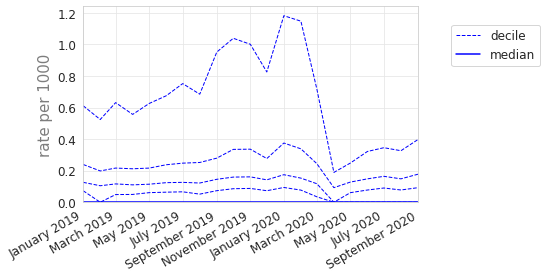

Top codes represented in chart above:

,first_digits,2020 events (thou),Description


In [2]:
keywords = ["Nervous system and mental state", "Neurotic, personality and other nonpsychotic disorders"]
highlevel, detailed = load_filter_codelists(keywords=keywords)

# descriptions for ctv3 codes    
codes = pd.read_csv(os.path.join('..','data','code_dictionary.csv'))

plotting_all(highlevel, codes, 3, 1000, dbconn, True)



In [4]:
######################### customise ################################
# Create lists of keywords and/or CTV3 concepts to filter codelist
keywords = ["mental", "learning", "dementia", "deleri", "psycho", "depress", "anxi", "cogn"]
concepts = ["Mental health disorder"]

display(Markdown(f"## Load list of common codes from csv and filter to Mental Health activity only"))
####################################################################


highlevel, detailed = load_filter_codelists(keywords=keywords, concepts=concepts)

subset = highlevel.copy()
d = np.where(subset["digits"].max()==5, 3, 2)
c = subset.loc[subset["digits"]==d] # select only codes with the min number of digits 
                                        # (either all are 2, or there is a mix of 3 & 5, where only the 3-digit ones need a list of sub codes producing)
c = tuple(subset["first_digits"])

from functions import get_subcodes
subcodes = get_subcodes(c, codes, d, 1000, dbconn)
subcodes

## Load list of common codes from csv and filter to Mental Health activity only

High level codes: 14

Detailed codes: 3

,first_digits,parent_code,2020 events (thou),Description
0,E200,E2,85.0,Anxiety disorder
1,E200z,E2,59.8,Anxiety state NOS
2,E2273,E2,21.9,Erectile dysfunction
3,E2002,E2,21.4,Generalised anxiety disorder
4,E2B,E2,14.7,Depressive disorder NEC
...,...,...,...,...
68,d571,d5,1.3,Clopixol 200mg/1mL oily injection
69,d516,d5,1.1,Depixol Conc 100mg/1mL oily injection
70,E01y0,E0,3.2,Alcohol withdrawal syndrome
71,Ez,Ez,1.2,Mental disorders NOS
